In [48]:
# importamos las librerías que necesitamos
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

In [150]:
df1 = pd.read_csv("Files/Customer Flight Activity.csv")

In [50]:
columnas_traducidas = {
    'Loyalty Number': 'numero_cliente',
    'Year': 'ano',
    'Month': 'mes',
    'Flights Booked': 'vuelos_reservados',
    'Flights with Companions': 'vuelos_con_acompanantes',
    'Total Flights': 'total_vuelos',
    'Distance': 'distancia',
    'Points Accumulated': 'puntos_acumulados',
    'Points Redeemed': 'puntos_canjeados',
    'Dollar Cost Points Redeemed': 'costo_en_dolares_de_los_puntos_canjeados'
}
df1.rename(columns= columnas_traducidas, inplace=True)

Vamos a eliminar las filas duplicadas

In [51]:
# Comprobamos el numero de duplicados
print(f"El número de duplicados es {df1.duplicated().sum()}")
# comprobamos el numero de filas
print(f"El número de filas antes de borrar los duplicados es {df1.shape[0]}")
# Eliminamos los duplicados
df1.drop_duplicates(inplace=True)
# Comprobamos
print(f"El número de filas después de borrar los duplicados es {df1.shape[0]}")
print(f"El cálculo es correcto {405624-1864}")

El numero de duplicados 1864
El numero de filas antes de borrar los duplicados es 405624
El numero de filas después de borrar los duplicados es 403760
El calculo es correcto 403760


In [55]:
df1.describe()

,numero_cliente,ano,mes,vuelos_reservados,vuelos_con_acompanantes,total_vuelos,distancia,puntos_acumulados,puntos_canjeados,costo_en_dolares_de_los_puntos_canjeados
count,403760.000000,403760.000000,403760.000000,403760.000000,403760.000000,403760.000000,403760.000000,403760.000000,403760.000000,403760.000000
mean,549875.383713,2017.500352,6.501335,4.134050,1.036569,5.170619,1214.460979,124.263761,30.838587,2.495973
std,258961.514684,0.500000,3.451982,5.230064,2.080472,6.526858,1434.098521,146.696179,125.758002,10.172033
min,100018.000000,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,326699.000000,2017.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,550598.000000,2018.000000,7.000000,1.000000,0.000000,1.000000,525.000000,53.000000,0.000000,0.000000
75%,772152.000000,2018.000000,10.000000,8.000000,1.000000,10.000000,2342.000000,240.000000,0.000000,0.000000
max,999986.000000,2018.000000,12.000000,21.000000,11.000000,32.000000,6293.000000,676.500000,876.000000,71.000000


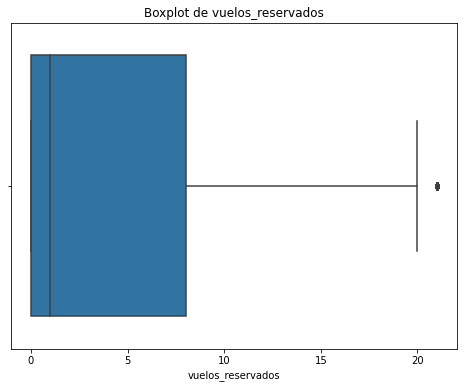

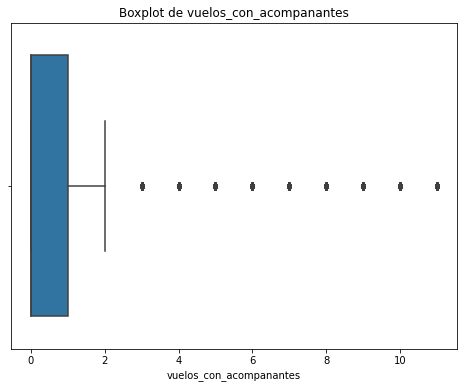

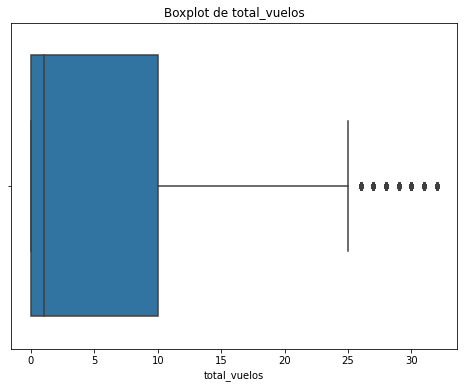

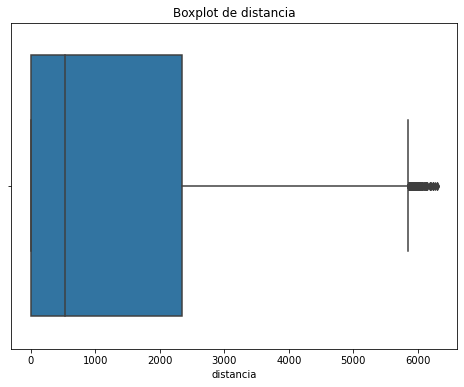

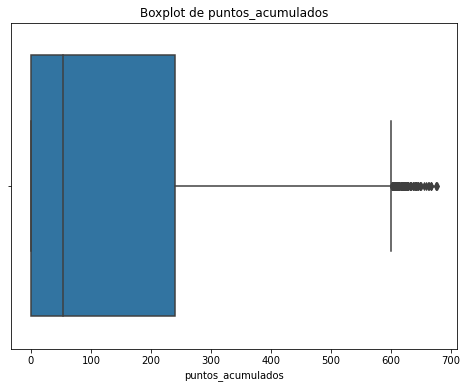

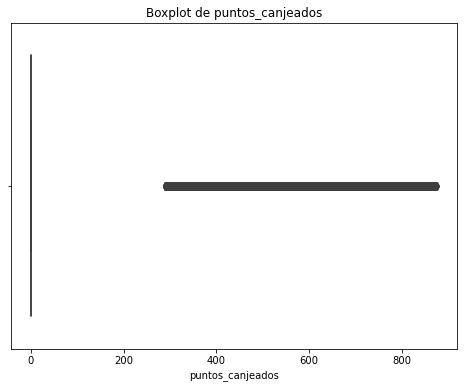

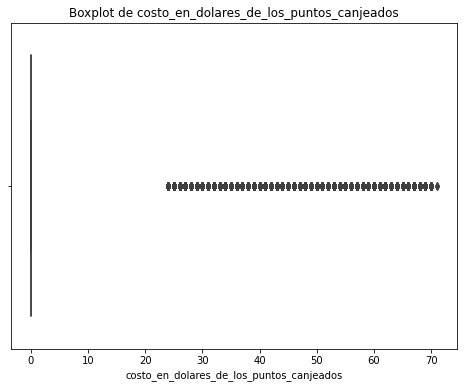

In [74]:
for columna in df1.iloc[:,3:]:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df1[columna])
    plt.title(f'Boxplot de {columna}')
    plt.xlabel(columna)
    plt.show()

In [129]:
df1[df1["costo_en_dolares_de_los_puntos_canjeados"]!=0].shape[0]/df1.shape[0]*100

5.988953833960768

In [130]:
df1[df1["costo_en_dolares_de_los_puntos_canjeados"]==0].shape[0]/df1.shape[0]*100

94.01104616603924

Cerca del 6% realiza coste canjando puntos  --> Analicemos esta media

El 94% no causa coste canjeando puntos

In [131]:
df_con_gasto = df1[df1["costo_en_dolares_de_los_puntos_canjeados"]!=0]

In [133]:
df_con_gasto["costo_en_dolares_de_los_puntos_canjeados"].describe()

count    24181.000000
mean        41.676275
std          9.736304
min         24.000000
25%         34.000000
50%         41.000000
75%         48.000000
max         71.000000
Name: costo_en_dolares_de_los_puntos_canjeados, dtype: float64

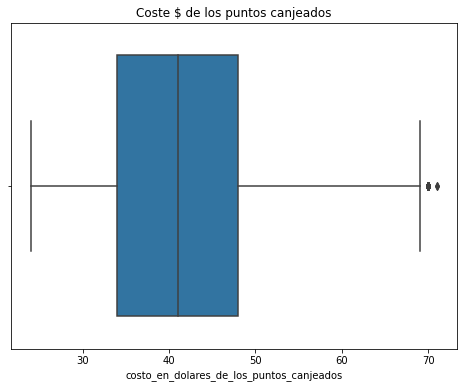

In [136]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = df_con_gasto["costo_en_dolares_de_los_puntos_canjeados"]);
plt.title(f"Coste $ de los puntos canjeados")
# plt.xlabel(columna)
plt.show()

Esto ya nos deja ver cual es el coste de la gente que canjea puntos. Vamos a comprobar pero debe de estar relacionado con los puntos canjeados

In [137]:
df1[df1["puntos_canjeados"]!=0].shape[0]/df1.shape[0]*100

5.988953833960768

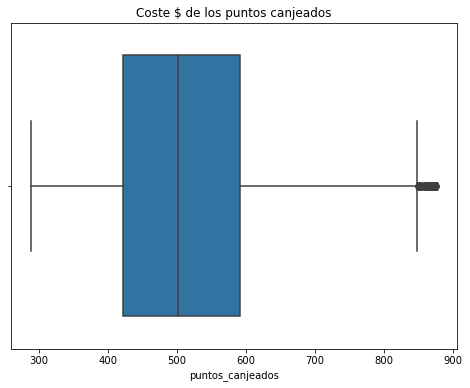

In [138]:
plt.figure(figsize=(8, 6))
sns.boxplot(x= df_con_gasto["puntos_canjeados"]);
plt.title(f"Coste $ de los puntos canjeados")
# plt.xlabel(columna)
plt.show()

Efectivamente parece que esta relacionado 